# VGG Follow Things Around

Follow Things Around is a program to detect and track multiple
objects in videos.  We currently support the tracking of chimpanzee
faces, birds, cats, dogs, horses, sheep, cows, elephants, bears,
zebras, and giraffes and are expanding the list of things that it
can track.  Please contact us at if you are interested in tracking
other things.

Follow Things Around works by performing a two-step approach named
"tracking by detection".  First, it detect the "things" of interest
in all frames of a video and then, it tracks those detections
merging them into individual tracks and filling in gaps from the
detector.

## 1 - Read Me First

This project is a [Jupyter](https://jupyter.org/) notebook to
perform tracking by detection of multiple objects in videos and was
designed to run in [Google
Colab](https://colab.research.google.com/).  If you are not reading
this notebook in Google Colab, click
[here](https://colab.research.google.com/github/ox-vgg/follow-things-around/blob/main/tracking.ipynb).


### 1.1 - What is, and how to use, a Jupyter notebook

A Jupyter notebook is a series of "cells".  Each cell contains either
text (like this one) or code (like others below).  A cell that
contains code will have a "Run cell" button on the left side like this
"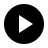".
When you click the "Run cell" button, the code in that cell will run
and when it finishes, a green check mark appears next to the "Run
cell" button".  You need to wait for the code in that cell to finish
before "running" the next cell.


### 1.2 - Particulars of this notebook

This notebook was designed to run in Google Colab and to analyse
videos in Google Drive.  It will also save back the analysis results
in Google Drive.  As such, it requires a Google account.

You must run the cells on this notebook one after the other since each
cell is dependent on the results of the previous cell.

This notebook also some interactive cells, namely in the options
sections.  After setting their values, these cells must be run, just
like other code cells.  Setting their values only has effect after you
"run" their cell.

### 1.3 - Testing this notebook

We recommend you first test this notebook with a short video, less
than 20 seconds long.  First, try our own sample video to track
chimpanzee faces (download it
[here](https://thor.robots.ox.ac.uk/software/chimpanzee-tracking/test-data/19-mini.mp4)).
Then try a video fragment of your own video.  Finally, run it on
your full video.

### 1.4 - Results files

This notebook will save all results for a single video in one
directory.  It will generate the following files:

- `frames` - a directory with the individual video frames.  You may
  want to delete them after validating the results.  They take up a
  lot of space and can be regenerated later.

- `detections.pkl` - the initial detections in [Python's pickle
  format](https://docs.python.org/3/library/pickle.html).

- `detections-via.json` - the initial detections as a
  [VIA 2](https://www.robots.ox.ac.uk/~vgg/software/via/) project.
  This requires the images in the `frames` directory.

- `tracks.pkl` - the detected tracks in [Python's pickle
  format](https://docs.python.org/3/library/pickle.html).

- `results-via-project.json` - the final detections as a [VIA
  2](https://www.robots.ox.ac.uk/~vgg/software/via/) project.  This
  requires the images in the `frames` directory.

- `results.csv` - the final detections in CSV format.

- `tracks.mp4` - video with tracks (see Section 6).

Note that none of those files includes the input video filename.
Our recommendation is to create separate results directory for each
video.


### 1.5 - GPU access

A GPU is required to run this pipeline in a sensible manner.  For
example, without a GPU, a two minutes video will take close to two
hours to process.

By default, this notebook will run with a GPU.  However, it is
possible that you were not allocated one, typically because you've
used up all your GPU resources.  You can confirm this, and possibly
change it, manually.  To do that, navigate to "Edit" -> "Notebook
Settings" and select "GPU" from the "Hardware Accelerator" menu.


### 1.6 - Moving forward

You can run this notebook on Google Colab but if you have a large
collection of videos or if your videos are particularly long or have
a high number of objects to track, you may end up using up all of
your free Colab resources.

Once you've tested Follow Things Around with a few of your videos,
it may be worth running this on your own computers.  Contact us if
you need help to do that.  Alternatively, you can purchase
additional "compute units" with [Google Colab
Plans](https://colab.research.google.com/signup).


## 2 - Setup


### 2.1 - Check for GPU access


In [ ]:
#@markdown By default, this notebook will run with a GPU.  However, it
#@markdown is possible that you were not allocated one.  If you get a
#@markdown message saying that you do not have access to a GPU,
#@markdown navigate to "Edit" -> "Notebook Settings" and select "GPU"
#@markdown from the "Hardware Accelerator" menu.  Once you change it,
#@markdown you need to run this cell again.

import torch.cuda

if torch.cuda.is_available():
    USE_GPU = True
    print("You are using this GPU:")
    print(
        "GPU %d: %s (%d GB)"
        % (
            torch.cuda.current_device(),
            torch.cuda.get_device_name(),
            torch.cuda.get_device_properties(
                torch.cuda.current_device()
            ).total_memory
            * 1e-9,
        )
    )
else:
    USE_GPU = False
    print("You are NOT connected to a GPU.  This will run very slow.")
    print("Consider reconnecting to a runtime with GPU access.")

### 2.2 - Install and load dependencies


In [ ]:
#@markdown This step can take a few of minutes to finish.

# We only need install follow-things-around but that depends on SVT
# and Detectron2 which are not available on PyPI, so pip won't be able
# to find them, and we have to install them ourselves from their git
# repos.

# Using `pip install --quiet` is not enough, it still prints out a
# mysterious "Preparing metadata (setup.py)" message which is why we
# redirect stdout to `/dev/null`.  Important messages should go to
# stderr anyway.

# The SVT package
# https://www.robots.ox.ac.uk/~vgg/projects/seebibyte/software/svt/
print("Installing SVT")
!pip install --quiet git+https://gitlab.com/vgg/svt/ > /dev/null

# The Detectron2 package
# https://github.com/facebookresearch/detectron2/
print("Installing detectron2 (this will take a few minutes to finish)")
!pip install --quiet git+https://github.com/facebookresearch/detectron2.git > /dev/null

# Finally, Follow-Things-Around
print("Installing Follow-Things-Around")
!pip install --quiet 'follow-things-around[colab] @ git+https://github.com/ox-vgg/follow-things-around.git'

import glob
import json
import logging
import os
import os.path
import pickle

import google.colab.drive
import google.colab.output
import requests
import torch

import follow_things_around
from follow_things_around import (
    detect,
    ffmpeg_video_to_frames,
    filter_detections,
    make_video_with_tracks,
    track,
    FramesDirDataset,
)
from follow_things_around.via import detections_to_via2
from follow_things_around.widgets import display_detections

logging.basicConfig()
_logger = logging.getLogger()

### 2.3 - Mount Google Drive


In [ ]:
#@markdown When you run this cell, a dialog will appear about a
#@markdown request for access to your Google Drive Files.  This is
#@markdown required to access the videos for analysis and to then save
#@markdown the results.  Once you click on "Connect to Google Drive",
#@markdown a pop-up window will appear to choose a Google Account and
#@markdown then to allow access to "Google Drive for desktop".

google.colab.drive.mount('/content/drive')

### 2.4 - Select "thing" to track


In [ ]:
#@markdown A model trained on the "thing" of interest is required.  We
#@markdown currently have models for these things but it is possible
#@markdown to train new ones.  Please contact us if you require a
#@markdown detector for something else or if you require to fine-tune
#@markdown them.
#@markdown
#@markdown Do not forget to "run" this cell after making your
#@markdown selection.

THING_TO_TRACK = "Chimpanzee faces"  #@param ["Chimpanzee faces", "Chimpanzee bodies", "Birds", "Cats", "Dogs", "Horses", "Sheep", "Cows", "Elephants", "Bears", "Zebras", "Giraffes"]

THING_TO_MODEL_CONFIG = {
    "Chimpanzee faces": {
        "config-url": "https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/mask_rcnn_R_50_FPN_LSJ-CFbootstrap.py",
        "class-idx": 0,
    },
    "Chimpanzee bodies": {
        "config-url": "https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/mask_rcnn_R_50_FPN_LSJ-imdb_5k_sup.py",
        "class-idx": 0,
    },
    "Birds": {
        "config-url": "https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/mask_rcnn_R_50_FPN_400ep_LSJ-coco2017.py",
        "class-idx": 14,
    },
    "Cats": {
        "config-url": "https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/mask_rcnn_R_50_FPN_400ep_LSJ-coco2017.py",
        "class-idx": 15,
    },
    "Dogs": {
        "config-url": "https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/mask_rcnn_R_50_FPN_400ep_LSJ-coco2017.py",
        "class-idx": 16,
    },
    "Horses": {
        "config-url": "https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/mask_rcnn_R_50_FPN_400ep_LSJ-coco2017.py",
        "class-idx": 17,
    },
    "Sheep": {
        "config-url": "https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/mask_rcnn_R_50_FPN_400ep_LSJ-coco2017.py",
        "class-idx": 18,
    },
    "Cows": {
        "config-url": "https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/mask_rcnn_R_50_FPN_400ep_LSJ-coco2017.py",
        "class-idx": 19,
    },
    "Elephants": {
        "config-url": "https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/mask_rcnn_R_50_FPN_400ep_LSJ-coco2017.py",
        "class-idx": 20,
    },
    "Bears": {
        "config-url": "https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/mask_rcnn_R_50_FPN_400ep_LSJ-coco2017.py",
        "class-idx": 21,
    },
    "Zebras": {
        "config-url": "https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/mask_rcnn_R_50_FPN_400ep_LSJ-coco2017.py",
        "class-idx": 22,
    },
    "Giraffes": {
        "config-url": "https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/mask_rcnn_R_50_FPN_400ep_LSJ-coco2017.py",
        "class-idx": 23,
    },
}

if THING_TO_TRACK not in THING_TO_MODEL_CONFIG:
    raise Exception(
        'THING_TO_TRACK \'%s\' has no pre-configuration \'%s\''
        % (THING_TO_TRACK, list(THING_TO_MODEL_CONFIG.keys()))
    )

### 2.5 - Video file and results folder


In [ ]:
#@markdown To find the correct path, open the "Files" menu in the left
#@markdown sidebar.  The `drive` directory contains your Google Drive
#@markdown files.  Navigate the files, right click on the wanted file
#@markdown or directory, and select "Copy path".  Then paste the path
#@markdown in this form.  Do not forget to then "run" this cell.

VIDEO_FILE = ''  #@param {type:"string"}
RESULTS_DIRECTORY = ''  #@param {type:"string"}

if not VIDEO_FILE:
    raise Exception('VIDEO_FILE is empty, you must set it.')
if not RESULTS_DIRECTORY:
    raise Exception('RESULTS_DIRECTORY is empty, you must set it.')
if not os.path.isfile(VIDEO_FILE):
    raise Exception('The VIDEO_FILE \'%s\' does not exist' % VIDEO_FILE)
if not os.path.isdir(RESULTS_DIRECTORY):
    raise Exception(
        'The RESULTS_DIRECTORY \'%s\' does not exist' % RESULTS_DIRECTORY
    )

### 2.6 - Advanced options

The cells hidden in this section expose the advanced options for this
pipeline and perform the final setup.  In most cases you do not need
to change their values.  You can click the "Run cell" button to run
all the hidden cells inside.


In [ ]:
#@markdown #### 2.6.1 - Detection step

#@markdown The detection step is the first step.  It detects the
#@markdown location of the "things" of interest in all frames of the
#@markdown video.

#@markdown A detection model is required.  You can either train
#@markdown your own model, or you can use one of our pre-trained
#@markdown models.  This variable is the URL, or file path, for a
#@markdown detectron2 model configuration (the URI and file path for
#@markdown the model weights are specified in the config file).
#@markdown

#@markdown Leave this empty to use the pre-configured model to detect
#@markdown the `THING_TO_TRACK` choosen in Section 2.4.

DETECTION_MODEL_CONFIG_URL = ''  #@param {type: "string"}
DETECTION_CLASS_IDX = 0
if not DETECTION_MODEL_CONFIG_URL:
    DETECTION_MODEL_CONFIG_URL = THING_TO_MODEL_CONFIG[THING_TO_TRACK]["config-url"]
    DETECTION_CLASS_IDX = THING_TO_MODEL_CONFIG[THING_TO_TRACK]["class-idx"]

#@markdown When the model detects something, that detection is
#@markdown made with a confidence score.  Detections with a confidence
#@markdown score lower than the threshold will be ignored during
#@markdown tracking.  If you set the threshold too high, you may miss
#@markdown detections in some frames which need to be filled by the
#@markdown tracker..  If you set it too low, false detections will
#@markdown lead to false tracks that need to be manually removed
#@markdown later.

DETECTION_THRESHOLD = 0.9  #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}

In [ ]:
#@markdown #### 2.6.2 - Tracking step

#@markdown The final step is to merge the detections into individual
#@markdown tracks.

#@markdown You will need to provide a model for the tracker.  We
#@markdown recommend you use [this
#@markdown one](https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/tracking-model-20181031_e45.pth).
#@markdown Alternatively, you can also specify a path in your Google
#@markdown Drive.
TRACKING_MODEL_URL = 'https://thor.robots.ox.ac.uk/models/staging/chimp-tracking/tracking-model-20181031_e45.pth'  #@param {type: "string"}

MATCH_OVERLAP_THRESHOLD = 0.2  #@param {type:"slider", min:0.0, max:1.0, step:0.01}

NONMATCH_TRACKING_THRESHOLD = 0.9  #@param {type:"slider", min:0.0, max:1.0, step:0.01}

UNKNOWN_TRACK_ID_MARKER = -1

In [ ]:
#@markdown #### 2.6.3 - Verbosity

#@markdown How chatty do you want the notebook to be?  INFO is a good
#@markdown choice if you want to have a feeling for progress.
LOG_LEVEL = 'INFO'  #@param ["CRITICAL", "ERROR", "WARNING", "INFO", "DEBUG"]

In [ ]:
#@markdown #### 2.6.4 - The final setup step

#@markdown Run this cell to perform the final pipeline setup based on
#@markdown the given options.

logging.getLogger().setLevel(LOG_LEVEL)

FRAMES_DIR = os.path.join(RESULTS_DIRECTORY, 'frames')
DETECTIONS_PKL_FPATH = os.path.join(RESULTS_DIRECTORY, 'detections.pkl')
DETECTIONS_VIA_FPATH = os.path.join(RESULTS_DIRECTORY, 'detections-via.json')
TRACKS_PKL_FPATH = os.path.join(RESULTS_DIRECTORY, 'tracks.pkl')
RESULTS_VIA_FPATH = os.path.join(RESULTS_DIRECTORY, 'results-via-project.json')
RESULTS_CSV_FPATH = os.path.join(RESULTS_DIRECTORY, 'results.csv')
TRACKS_VIDEO_FPATH = os.path.join(RESULTS_DIRECTORY, 'tracks.mp4')


# These should never be true because USE_GPU was set automatically
# based on whether a GPU is available.
if USE_GPU and not torch.cuda.is_available():
    raise Exception('Your runtime does not have a GPU.')
elif torch.cuda.is_available() and not USE_GPU:
    _logger.warn('You have a GPU but chose to not use it.  Are you sure?')

if USE_GPU:
    DEFAULT_DEVICE = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    DEFAULT_DEVICE = 'cpu'
    torch.set_default_tensor_type('torch.FloatTensor')

_logger.info('Will use %s device.', DEFAULT_DEVICE.upper())


# Required to display the tracking results with plotly or matplotlib.
google.colab.output.enable_custom_widget_manager()


follow_things_around.DEFAULT_DEVICE = DEFAULT_DEVICE
follow_things_around.FRAMES_DIR = FRAMES_DIR
follow_things_around.MATCH_OVERLAP_THRESHOLD = MATCH_OVERLAP_THRESHOLD
follow_things_around.NONMATCH_TRACKING_THRESHOLD = NONMATCH_TRACKING_THRESHOLD
follow_things_around.UNKNOWN_TRACK_ID_MARKER = UNKNOWN_TRACK_ID_MARKER
follow_things_around.USE_GPU = USE_GPU
follow_things_around.VIDEO_FILE = VIDEO_FILE

logging2ffmpeg_loglevel = {
    'CRITICAL': 'fatal',
    'ERROR': 'error',
    'WARNING': 'warning',
    'INFO': 'info',
    'DEBUG': 'debug',
}
follow_things_around.FFMPEG_LOG_LEVEL = logging2ffmpeg_loglevel[LOG_LEVEL]

## 3 - Convert video to frames

The pipeline needs the video frames as individual image files.  This
cell will create a `frames` directory and save the individual images
there.  You may skip running this cell if you already have a `frames`
directory with images.  This cell will error if the `frames` directory
already exists to prevent overwriting any existing data.


In [ ]:
#@markdown Skip this cell if you already have the frames.  If you run
#@markdown this cell and the `frames` directory already exists, it
#@markdown errors to avoid overwriting any previous images.

os.makedirs(FRAMES_DIR, exist_ok=False)

ffmpeg_video_to_frames(VIDEO_FILE, FRAMES_DIR)

_logger.info('Finished extracting individual frames to \'%s\'', FRAMES_DIR)

## 4 - Detection step

The detection of "things" is the first step in the pipeline.  If you
have previously run the detection step then you will have a
`detections.pkl` file in the results directory.  If so, skip the
"Run detection" cell (section 4.1) and run the "Load previous
detections results" cell instead (section 4.2).


In [ ]:
#@markdown ### 4.1 - Run detection (option 1)

dataset = FramesDirDataset(FRAMES_DIR)
if len(dataset) == 0:
    raise Exception(
        "No files in '%s'.  Did you run the previous section which converts"
        " the video to frames?" % FRAMES_DIR
    )

detections = detect(dataset, DETECTION_MODEL_CONFIG_URL, DETECTION_CLASS_IDX)

with open(DETECTIONS_PKL_FPATH, 'wb') as fh:
    pickle.dump({'detections': detections}, fh)
_logger.info("Detection results saved to '%s'", DETECTIONS_PKL_FPATH)

with open(DETECTIONS_VIA_FPATH, 'w') as fh:
    json.dump(detections_to_via2(dataset, detections), fh)
_logger.info("Detection VIA project saved to '%s'", DETECTIONS_VIA_FPATH)

In [ ]:
#@markdown ### 4.2 - Load previous detection results (option 2)

dataset = FramesDirDataset(FRAMES_DIR)
if len(dataset) == 0:
    raise Exception(
        "No files in '%s'.  Did you run the previous section which converts"
        " the video to frames?" % FRAMES_DIR
    )

with open(DETECTIONS_PKL_FPATH, 'rb') as fh:
    loaded_detections = pickle.load(fh)
detections = loaded_detections['detections']

_logger.info('Detection results loaded from \'%s\'', DETECTIONS_PKL_FPATH)

## 5 - Tracking step

The final step in the pipeline is to track the things detected in
the detection step.  At the end of this step, the tracking results
will be saved in a CSV file and as a
[VIA](https://www.robots.ox.ac.uk/~vgg/software/via/) project.

If you have previously run the tracking step then you will have a
`tracks.pkl` file in the results directory.  If so, skip the "Run
tracking" cell (section 5.1) and run the "Load previous tracking
results" cell instead (section 5.2).

In [ ]:
#@markdown ### 5.1 - Run tracking (option 1)

tracks = track(
    dataset,
    filter_detections(detections, DETECTION_THRESHOLD),
    TRACKING_MODEL_URL,
)

tracks.export_via_project(
    RESULTS_VIA_FPATH,
    config={
        'frame_img_dir': dataset.frames_dir,
        'via_project_name': '',
    },
)
tracks.export_plain_csv(RESULTS_CSV_FPATH, {})

with open(TRACKS_PKL_FPATH, 'wb') as fh:
    pickle.dump({'tracks': tracks}, fh)
_logger.info('Tracking results saved to \'%s\'', TRACKS_PKL_FPATH)

In [ ]:
#@markdown ### 5.2 - Load previous tracking results (option 2)

with open(TRACKS_PKL_FPATH, 'rb') as fh:
    loaded_tracks = pickle.load(fh)
tracks = loaded_tracks['tracks']

_logger.info('Tracking results loaded from \'%s\'', TRACKS_PKL_FPATH)

## 6 - Visualise results


### 6.1 - Visualise in Google Colab (option 1)


In [ ]:
#@markdown You can see the tracking results right here, inside this
#@markdown Google Colab notebook, but the interface is a bit slow.
#@markdown This is fine if you want to have a quick look at some of
#@markdown of frames only.

#@markdown Run this cell and then click on the arrow buttons to
#@markdown display the next or previous frame, and you can move the
#@markdown slider to move to a specific frame.  When you dragging the
#@markdown slider, the displayed frame is only updated once the slider
#@markdown is released.  Expect a couple of seconds wait for the frame
#@markdown to be updated.

display_detections(dataset, tracks.detection_data['0'])

### 6.2 - Visualise locally with VIA (option 2)


[VIA](https://www.robots.ox.ac.uk/~vgg/software/via/) is a web
application to view and perform annotations of image, audio, and
video.  It is free software and runs locally on the web browser.  You
can view the tracking results on the individual frames with VIA.

This is much more responsive than viewing inside the notebook but
requires download the frames locally (either manually or with [Google
Drive for
Desktop](https://support.google.com/a/users/answer/13022292)).

1. Download [VIA
   2](https://www.robots.ox.ac.uk/~vgg/software/via/downloads/via-2.0.12.zip).
   This is a zip file.  Open it.  Inside there is a `via.html` file.
   Open it in your web browser to start VIA.

2. Download the `results-via-project.json` from your results diretcory
   and the whole frames directory.  If you are using Google Drive for
   Desktop sync it now.  The frames directory is pretty large and this
   step may take a long time.

3. Navigate to "Project" -> "Load" and select the
   `results-via-project.json` file.  A "File Not Found" error message
   will appear.  This means that VIA does not know where the images
   are.

4. Navigate to "Project" -> "Settings".  Set the "Default Path" to the
   `frames` directory in your computer.


### 6.3 - Create video file with tracks (option 3)


In [ ]:
#@markdown You may also generate a video file with the detections
#@markdown superimposed.  The video file will be named `tracks.mp4`
#@markdown and saved in the `RESULTS_DIRECTORY` in your Google Drive.

make_video_with_tracks(
    VIDEO_FILE, TRACKS_VIDEO_FPATH, FRAMES_DIR, RESULTS_CSV_FPATH
)
_logger.info('Video file with tracks created \'%s\'', TRACKS_VIDEO_FPATH)